# MEPs in diseased vs healthy mice

In [1]:
from tqdm import tqdm
from mepextract.extracting import Extractor
from scipy.signal import find_peaks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import os
import pickle
import json

plt.style.use(['science', 'grid', 'custom', 'vibrant'])

## Defining relevant folders and paths

In [2]:
test = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MICE_EEG_2024 (93-102).csv'
full = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/MICE_EEG_2024 (93-257).csv'

spreadsheet = pd.read_csv(full)

master_folder = '/Volumes/STORAGE 1.0/UNIC Research/Motor Evoked Potentials/MEPSSEP_raw_data/post 93'
test_folder = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test'

spreadsheet

,session,animalID,cage,ear,phenotype,phenoCode,subrec,sessionClass,sessionType,currentLevel,stim_lvl,isoflo,trials_from,trials_to,notes
0,2024-03-07_18-03-10,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,1.49,thr,1.9,1.0,60,'A571 sciatic at threshold of 1.49mA 50us pulse'
1,2024-03-07_18-04-31,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,2.25,1.5x,1.9,1.0,60,'A571 sciatic at 1.5x thr 2.25mA 50us pulse'
2,2024-03-07_18-11-10,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,spine_hump,2.25,thr,1.9,1.0,60,'A571 spine hump at thr 2.75mA 200us pulse'
3,2024-03-07_18-12-24,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,spine_hump,4.12,1.5x,1.9,1.0,60,'A571 spine hump at 1.5xthr 4.12mA 200us pulse'
4,2024-03-07_18-26-03,A573,NaN,NaN,5XFAD,2.0,1.0,MEP,sciatic,3.37,thr,1.9,1.0,60,'A573 sciatic at 3.37mA 50us pulseA573 sciatic...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,2024-03-09_17-48-26,A572,NaN,NaN,5XFAD,2.0,1.0,MEP,skull_needles,6.00,max,1.9,1.0,60,'A572 LECB skull 6mA 200us 5 pulses'
161,2024-03-09_17-53-55,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,skull_needles,4.14,thr,1.9,1.0,60,'A571 RECB skull 4.14mA 200us 5 pulses'
162,2024-03-09_17-55-40,A571,NaN,NaN,5XFAD,2.0,1.0,MEP,skull_needles,6.20,1.5x,1.9,1.0,60,'A571 RECB skull 6.2mA 200us 5 pulses'
163,2024-03-09_18-06-40,A573,NaN,NaN,5XFAD,2.0,1.0,MEP,skull_needles,3.00,thr,1.9,1.0,60,'A573 thr skull 3mA 5 pulses 200usA573 thr sku...


## extracting MEPs for all trials

In [ ]:
# number of trials to iterate over
n = len(spreadsheet)
sampling_rate = 30000

extracted = []

for i in tqdm(range(0, n), desc="Processing trials"):
    if spreadsheet['sessionType'][i] == 'reject':
        continue
    else:
        # relevant information
        trial = spreadsheet.session[i]
        notes = spreadsheet.loc[i]
        
        # defining extractor object
        extractor = Extractor(
            master_folder=master_folder , 
            trial=trial, 
            notes=notes,
            recording_channels=[5, 7],
            sampling_rate=sampling_rate)
        extractor.pre_stimulus = 300
        extractor.post_stimulus = 3000
        
        # extracting relevant data
        extractor.extract_raw()
        extractor.extract_events(event_channel_number=13)
        extractor.get_event_data(export=False)
        
        detected = {'trial': trial, 'notes': notes, 'data': extractor.mep}
    
        extracted.append(detected)
    

In [12]:
# saving extracted data
with open('/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/extracted.pkl', 'wb') as f:
    pickle.dump(extracted, f)

In [5]:
# loading extracted data
extract_location = '/Users/fomo/Documents/Research/UNIC Research/Motor Evoked Potentials Test/extracted.pkl'

with open(extract_location, 'rb') as f:
    extracted = pickle.load(f)

## Gross peak extraction

In [9]:
from scipy.ndimage import gaussian_filter1d as gf

detected_peaks = []

sampling_rate = 30000
n = 10

# defining relevant channels, peak parameters, time axis and current level
time_in_ms = np.arange(-300, 3000) * (1/sampling_rate * 1000)
recording_channels = [5, 7]
search = {'height': (0, 100) ,'width': None, 'distance': None} # width = (0,50)

current_mean = spreadsheet['currentLevel'].mean()
current_std = spreadsheet['currentLevel'].std() 


fig, ax = plt.subplots(10, 1, figsize=(21, 7*10), dpi=210)

for iteration in tqdm(range(n), desc="Processing trials"):
    
    i = iteration%10
    
    temp = extracted[iteration]['data']
    current = extracted[iteration]['notes']['currentLevel']
    title = extracted[iteration]['notes']['session']
    group = int(extracted[iteration]['notes']['phenoCode'])

    delay = {'index': iteration, 'positive peaks': [], 'negative peaks': [], 'group': group, 'current': current}
    
    for channel in recording_channels:
        
        current = (current - current_mean)/current_std
        
        data = temp[channel, :, :]
        baseline = temp[channel, :10, :].mean(axis=1).mean(axis=0)
        correction = np.full((1, data.shape[0]), baseline)
        
        mean_events = (data.mean(axis=1)).flatten()
        std_events = (data.std(axis=1)).flatten()
        
        smoothed_mean = gf(mean_events, sigma=1.25)
        smoothed_std = gf(std_events, sigma=1.25)
        
        standardised = (1/current)*(smoothed_mean - smoothed_mean.mean())/smoothed_mean.std()
        
        pos_peaks, pos_parameters = find_peaks(standardised, height = search['height'], distance = search['distance'], width = search['width'])
        
        neg_peaks, neg_parameters = find_peaks(-standardised, height = search['height'], distance = search['distance'], width = search['width'])
        
        for peak in pos_peaks:
            if 330 < peak < 500 and standardised[peak] > 0.1:
                # ax[i].plot(time_in_ms[peak], standardised[peak], 'x', color='red')
                amplitude = standardised[peak]
                delay['positive peaks'].append((peak, amplitude))
        
        for peak in neg_peaks:
            if 330 < peak < 500 and standardised[peak] < -0.1:
                # ax[i].plot(time_in_ms[peak], standardised[peak], 'x', color='blue')
                amplitude = standardised[peak]
                delay['negative peaks'].append((peak, np.abs(amplitude)))
                
        detected_peaks.append(delay)
        
        ax[i].plot(time_in_ms, standardised, label=f'Channel {channel}')
        ax[i].fill_between(time_in_ms, standardised - 1, standardised + 1, alpha=0.5)

        ax[i].set_title(f'Trial {title}', fontsize=16)
        # ax[i].set_ylim()
        ax[i].set_xlim(-2, 10)
        ax[i].set_xlabel('Time (ms)', fontsize=14)
        ax[i].set_ylabel('Amplitude', fontsize=14)
        ax[i].legend()

plt.tight_layout()
plt.savefig('/Users/fomo/Desktop/45to55ms(first_ten_trials).png')
plt.show()


Processing trials: 100%|██████████| 10/10 [00:00<00:00, 156.01it/s]


## Refining peak selection

In [78]:
selected_peaks = []

verify = []

exclude = [44, 49, 50, 53, 55, 56, 57, 62, 63, 68, 73, 74, 80, 81, 86, 87, 92, 93, 94, 100, 101, 106, 107, 108, 109, 110, 111, 112, 113, 118, 123, 124, 125, 130, 131, 132, 134, 135, 137, 138, 140, 141, 142, 143]

for trial in detected_peaks_zone_1:
    
    if trial['index'] not in exclude:
        
        group = trial['group']
        current = trial['current']
        index = trial['index']
        
        # sort peaks by amplitude
        largest_peaks = []
        positive_peaks = (sorted(trial['positive peaks'], key=lambda x: x[1]))
        negative_peaks = (sorted(trial['negative peaks'], key=lambda x: x[1]))
        
        if len(positive_peaks)>0:
            largest_peaks.append(positive_peaks[-1])
        if len(negative_peaks)>0:
            largest_peaks.append(negative_peaks[-1])
        
        # sort peaks by time
        largest_peaks = sorted(largest_peaks, key=lambda x: x[0])
        
        #first positive peak': positive_peaks[-1], 'first negative peak': negative_peaks[-1], 
        if len(largest_peaks) > 0:
            selected_peaks.append({'group': group, 'current': current, 'first_large_peak': largest_peaks[0]})
            if largest_peaks[0][0] <  345:
                verify.append(index)

seen = set()
verify = [item for item in verify if item not in seen and not seen.add(item)]

toVerify = []

for index, value in enumerate(verify):
    toVerify.append((extracted[value], value))

## Plotting delays vs amplitude

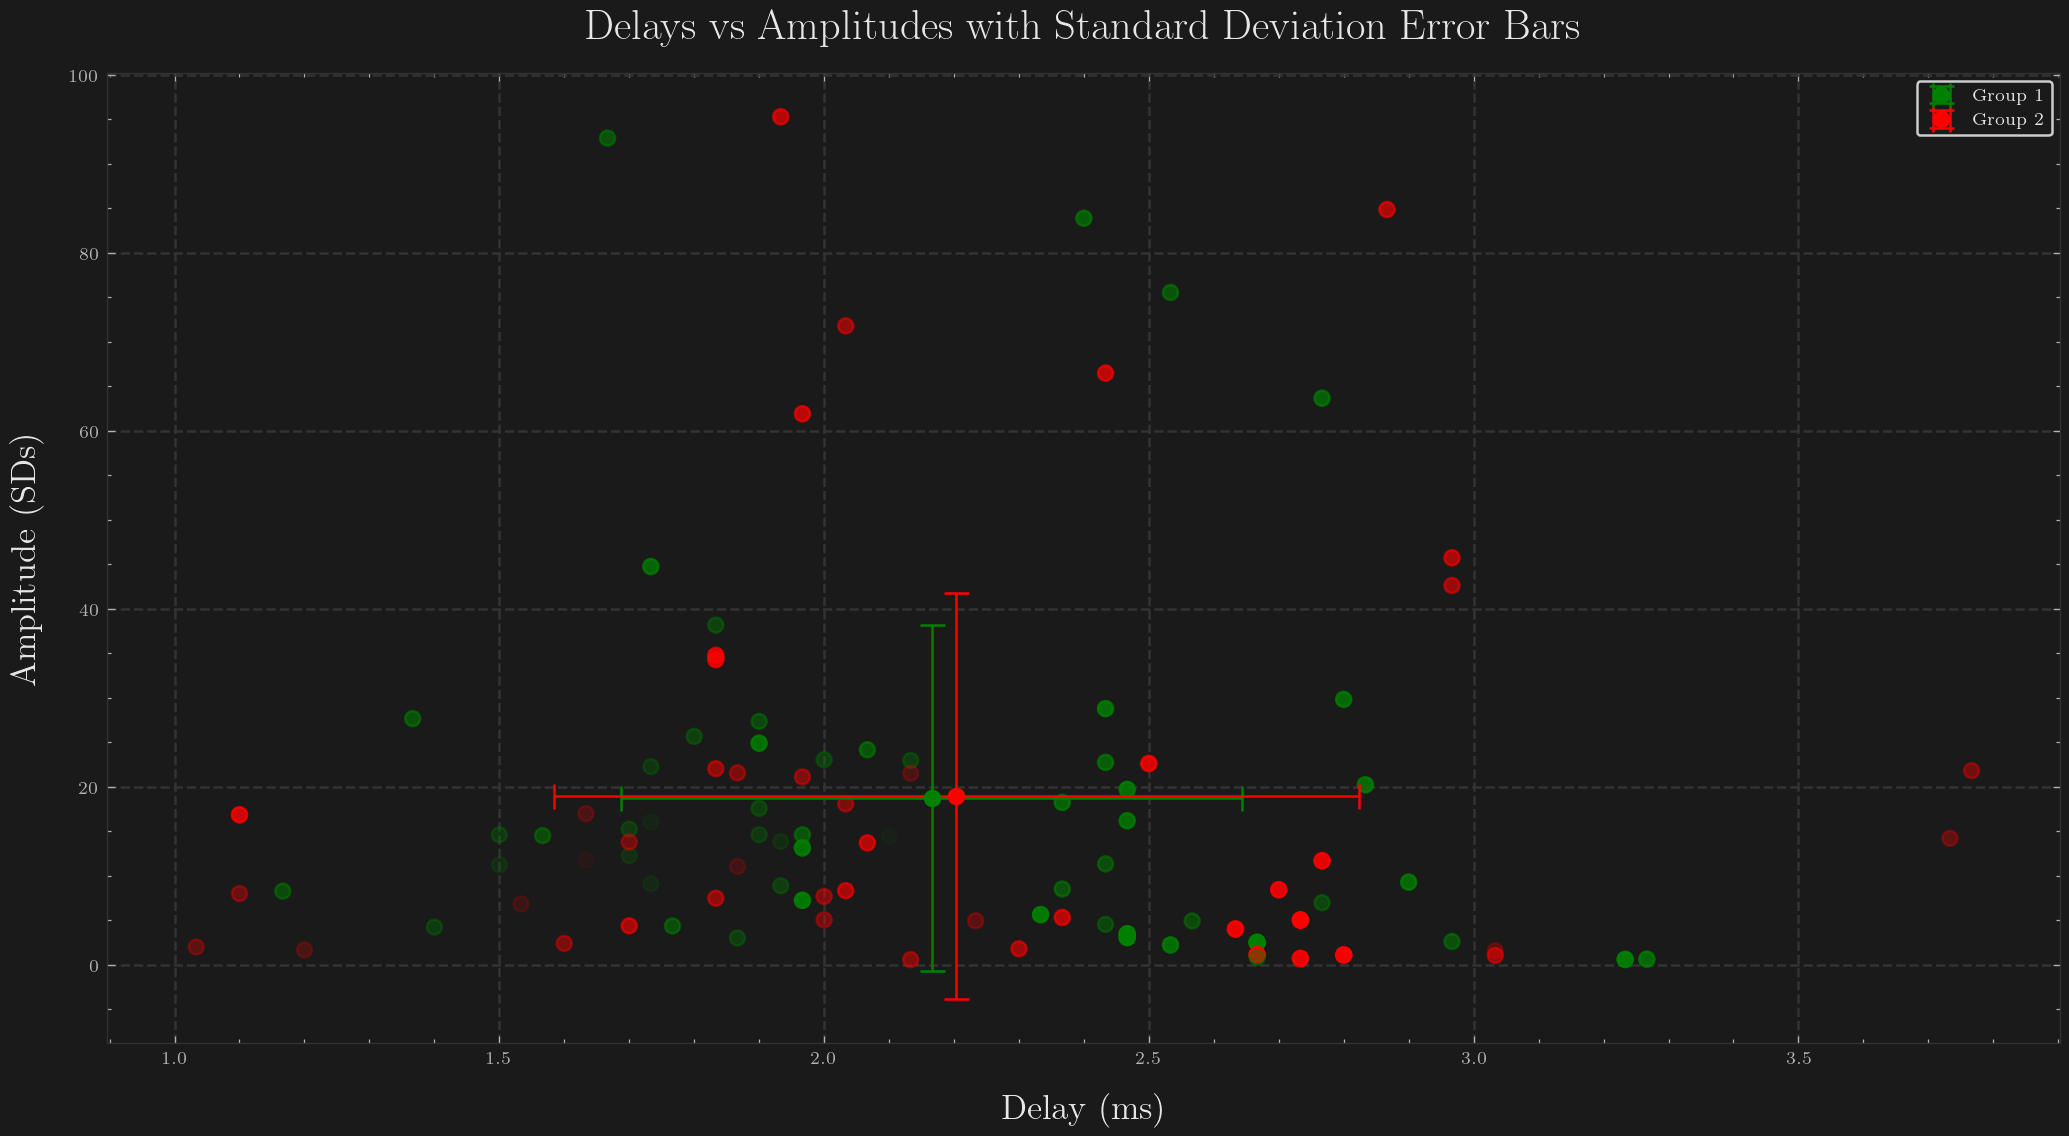

In [79]:
conversion = (1 / sampling_rate) * 1000

# Extract delays, amplitudes, and groups
delays = [peak['first_large_peak'][0]*conversion - 10 for peak in selected_peaks]
amplitudes = [peak['first_large_peak'][1] for peak in selected_peaks]
groups = [peak['group'] for peak in selected_peaks]
currents = [peak['current'] for peak in selected_peaks]

# min-max scaling current
from sklearn.preprocessing import MinMaxScaler

currents_2d = [[x] for x in currents] # 2-D array for MinMaxScaler() 
scaler = MinMaxScaler()
scaled_currents = scaler.fit_transform(currents_2d).flatten()

# separate data by group
group1_delays = [delays[i] for i in range(len(groups)) if groups[i] == 1]
group1_amplitudes = [amplitudes[i] for i in range(len(groups)) if groups[i] == 1]
group2_delays = [delays[i] for i in range(len(groups)) if groups[i] == 2]
group2_amplitudes = [amplitudes[i] for i in range(len(groups)) if groups[i] == 2]

# calculate means and standard deviations for delays and amplitudes for each group
mean_delay_1, std_delay_1 = np.mean(group1_delays), np.std(group1_delays)
mean_amplitude_1, std_amplitude_1 = np.mean(group1_amplitudes), np.std(group1_amplitudes)

mean_delay_2, std_delay_2 = np.mean(group2_delays), np.std(group2_delays)
mean_amplitude_2, std_amplitude_2 = np.mean(group2_amplitudes), np.std(group2_amplitudes)

# plotting
from matplotlib.colors import ListedColormap

plt.figure(figsize=(14, 7))
plt.scatter(delays, amplitudes, c=groups, cmap=ListedColormap( ['green', 'red']), alpha=scaled_currents)

# group 1 with error bars
plt.errorbar(mean_delay_1, mean_amplitude_1, xerr=std_delay_1, yerr=std_amplitude_1, fmt='o', color='green', label='Group 1', capsize=5)

# group 2 with error bars
plt.errorbar(mean_delay_2, mean_amplitude_2, xerr=std_delay_2, yerr=std_amplitude_2, fmt='o', color='red', label='Group 2', capsize=5)

# Adding labels and title
plt.xlabel('Delay (ms)', fontsize=14)
plt.ylabel('Amplitude (SDs)', fontsize=14)
plt.title('Delays vs Amplitudes with Standard Deviation Error Bars', fontsize=17)
plt.legend()
plt.savefig('/Users/fomo/Desktop/delays_vs_amplitudes.png')
plt.show()

## Statistical Tests

In [80]:
from scipy.stats import ttest_ind, mannwhitneyu, shapiro

shapiro_group1 = shapiro(group1_delays)
shapiro_group2 = shapiro(group2_delays)

print("Shapiro-Wilk test for Group 1 Delays: p-value =", shapiro_group1.pvalue)
print("Shapiro-Wilk test for Group 2 Delays: p-value =", shapiro_group2.pvalue)

# Determine if the data is normally distributed based on p-value > 0.05
if shapiro_group1.pvalue > 0.05 and shapiro_group2.pvalue > 0.05:
    # If data are approximately normal, use independent samples t-test
    t_stat, p_value = ttest_ind(group1_delays, group2_delays, equal_var=False)  # Welch's t-test
    print("Independent t-test p-value:", p_value)
else:
    # If data are not normally distributed, use Mann-Whitney U test
    u_stat, p_value = mannwhitneyu(group1_delays, group2_delays, alternative='two-sided')
    print("Mann-Whitney U test p-value:", p_value)

alpha = 0.05  
if p_value < alpha:
    print("The difference in delays between Group 1 and Group 2 is statistically significant.")
else:
    print("No statistically significant difference in delays between Group 1 and Group 2.")


Shapiro-Wilk test for Group 1 Delays: p-value = 0.020648904144763947
Shapiro-Wilk test for Group 2 Delays: p-value = 0.007519838400185108
Mann-Whitney U test p-value: 0.6530244966013955
No statistically significant difference in delays between Group 1 and Group 2.
